### Load informations

In [1]:
import os

try:
  
  from google.colab import files
  import shutil
  import zipfile

  def get_file(name, upload=True):
    if not os.path.exists(name) and upload:
      uploaded = files.upload()
      map = uploaded.values()
      if len(map) == 0:
        return False
      data = list(map)[0]
      with open(name, 'wb') as f:
        f.write(data)
    return os.path.exists(name)

  def get_path(filename, folder='./'):
      return filename

  def save_model(model, name):
    directory = '{}/{}/'.format('models', name)
    archive = '{}.zip'.format(name)
    if not os.path.exists(directory):
      os.makedirs(directory)
    model.save(os.path.join(directory, name))
    shutil.make_archive(name, 'zip', directory)
    print(archive)
    files.download(archive)

  def load_model(name, upload=True):
    archive = '{}.zip'.format(name)
    if get_file(archive, upload) == False:
      return None
    zip_ref = zipfile.ZipFile(archive, 'r')
    zip_ref.extractall('.')
    zip_ref.close()
    lda = models.LdaModel.load(name)
    return lda
  
except ImportError:
  
    def get_file(name, upload=True):
        return os.path.exists(name)

    def get_path(filename, folder='data'):
        return os.path.join('../{}/'.format(folder), filename)

    def save_model(model, name):
        directory = '{}/{}/'.format('../data/models', name)
        if not os.path.exists(directory):
            os.makedirs(directory)
        model.save(os.path.join(directory, name))

    def load_model(name, upload=True):
        directory = '{}/{}/'.format('../data/models', name)
        if os.path.exists(os.path.join(directory, name)):
            return models.LdaModel.load(os.path.join(directory, name))
        return None

In [2]:
import json

file = get_path("indexed_tweets.json")

get_file(file)

raw_data = json.load(open(file))
data = json.loads(raw_data)

In [3]:
corpus = []
companies = []
for company in data:
    name, _, tweet_list = company
    start = len(corpus)
    corpus += list(map(lambda x: x[1], tweet_list))
    companies.append((name, start, len(corpus), len(tweet_list)))

In [4]:
import numpy as np
from collections import Counter

corpus = np.array(corpus)
count = Counter(np.concatenate(corpus, 0))
dictionary = np.array(count.most_common())[:5000][:, 0]
dictionary[:10]

array(['via', 'cloud', 'new', 'see', 'will', 'now', 'top', 'ai', 'great',
       'data'], dtype='<U100')

### Generate matrix

In [6]:
import os

def count_word_for_company(word, company, corpus):
    counter = 0
    company_tweets = corpus[int(company[1]):int(company[2])]
    for tweet in company_tweets:
        for p in tweet:
            if p == word:
                counter += 1
    return counter

if not os.path.exists(get_path('matrix.npy')):
    matrix = np.array([[count_word_for_company(word, company, corpus) for word in dictionary] for company in companies])
    np.save(get_path('matrix.npy'), matrix)
else:
    matrix = np.load(get_path('matrix.npy')) 

matrix.shape

(22, 5000)

### Generate tweets matrix

In [7]:
if not os.path.exists(get_path('tweets_matrix.npy')):
    tweets_matrix = np.array([[1 if word in tweet else 0 for word in dictionary] for tweet in corpus])
    np.save(get_path('tweets_matrix.npy'), tweets_matrix)
else:
    tweets_matrix = np.load(get_path('tweets_matrix.npy'))

tweets_matrix.shape

(528190, 5000)

In [8]:
def make_unique_corpus(corpus, tweets_matrix):
    unique_corpus, indexes = np.unique(corpus, return_index=True)
    return unique_corpus, tweets_matrix[indexes]

unique_corpus, unique_tweets_matrix = make_unique_corpus(corpus, tweets_matrix)
len(unique_corpus), len(unique_tweets_matrix)

(369558, 369558)

In [9]:
def company_from_name(name, companies):
    for company in companies:
        if name == company[0]:
            return company
    raise Exception('No company for this address')

def company_id_from_name(name, companies):
    for i, company in enumerate(companies):
        if name == company[0]:
            return i
    raise Exception('No company for this address')

def tweets_from_company(name, companies):
    company = company_from_name(name, companies)
    return corpus[int(company[1]):int(company[2])]

def indexed_tweets_from_company(name, companies, limit=None):
    companies_tweets = tweets_from_company(name, companies)
    return [(unique_corpus.tolist().index(o), o) for o in companies_tweets[:limit]]

def vectors_from_company(name, companies, matrix):
    company = company_from_name(name, companies)
    return matrix[int(company[1]):int(company[2])]

### SVD

In [10]:
def diag(values, shape):
    D = np.zeros(shape)
    np.fill_diagonal(D, values)
    return D

In [11]:
U, S, VT = np.linalg.svd(matrix) 

SIGMA = diag(S, (U.shape[0], VT.shape[1]))

# U . SIGMA . VT = MATRIX
list(map(lambda vec: [int(round(n)) for n in vec] , np.dot(np.dot(U, SIGMA), VT)))

[[1503,
  1524,
  2119,
  1549,
  1366,
  1409,
  484,
  819,
  1531,
  623,
  653,
  1713,
  166,
  862,
  12,
  1254,
  923,
  1128,
  1185,
  481,
  1532,
  1258,
  263,
  771,
  1129,
  149,
  1191,
  600,
  1183,
  684,
  886,
  545,
  510,
  905,
  470,
  302,
  890,
  174,
  1034,
  1295,
  1223,
  802,
  582,
  239,
  670,
  1180,
  361,
  192,
  471,
  654,
  848,
  453,
  353,
  159,
  966,
  384,
  7,
  859,
  160,
  458,
  394,
  127,
  15,
  815,
  458,
  219,
  546,
  17,
  289,
  449,
  119,
  926,
  16,
  70,
  9,
  979,
  342,
  397,
  179,
  239,
  556,
  896,
  315,
  599,
  4,
  606,
  622,
  503,
  125,
  888,
  557,
  347,
  48,
  411,
  192,
  610,
  19,
  508,
  277,
  367,
  698,
  271,
  265,
  641,
  274,
  374,
  569,
  235,
  65,
  242,
  79,
  457,
  764,
  442,
  121,
  516,
  354,
  195,
  776,
  725,
  163,
  285,
  565,
  126,
  422,
  277,
  46,
  202,
  186,
  136,
  457,
  150,
  1039,
  12,
  155,
  44,
  474,
  514,
  222,
  428,
  683,
  263,
  4

In [12]:
# return eigen vectors of a given matrix sorted by the magnitude of its related eigen value
# most important vectors being ranked at the left 
def eigen_vectors(matrix):
    eigen_values, eigen_vectors = np.linalg.eigh(matrix)
    inc_tweet = np.argsort(-eigen_values)
    return eigen_vectors[:,inc_tweet]

In [13]:
directory = get_path("eigenvectors/")

if os.path.exists(directory):
    l_e_vec = np.load(directory + "l_e_vec.npy")
    e_val = np.load(directory + "e_val.npy")
    r_e_vec = np.load(directory + "r_e_vec.npy")
else:
    l_e_vec = eigen_vectors(np.dot(matrix, matrix.T))
    e_val = np.linalg.eigvals(np.dot(matrix, matrix.T))
    r_e_vec = eigen_vectors(np.dot(matrix.T, matrix))
    os.makedirs(directory)
    np.save(directory + 'l_e_vec.npy', l_e_vec)
    np.save(directory + 'e_val.npy', e_val)
    np.save(directory + 'r_e_vec.npy', r_e_vec)

In [14]:
for i, company in enumerate(companies):
    print ("{:50}".format(company[0]), l_e_vec[i][:2])

Adobe                                              [0.1784956  0.06618756]
airliquidegroup                                    [0.00574814 0.00246552]
Alstom                                             [0.00474526 0.00244129]
ArcelorMittal                                      [0.00842875 0.00365102]
Capgemini                                          [ 0.12026924 -0.0034963 ]
Cisco                                              [0.21071031 0.05206317]
ENGIEgroup                                         [0.00895334 0.00337464]
Forrester                                          [ 0.42031405 -0.89366828]
Generalelectric                                    [0.07748525 0.03270682]
Intel                                              [0.32922663 0.18097289]
MaerskLine                                         [0.00981647 0.00329792]
Oracle                                             [0.42143639 0.07343345]
orexad                                             [0. 0.]
orexad_FR                            

In [15]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(25, 25))
ax = fig.add_subplot(1,1,1)
for i in range(len(l_e_vec))[:100]:
    ax.scatter(l_e_vec[i,0], l_e_vec[i,1])
    ax.annotate(companies[i][0], (l_e_vec[i,0], l_e_vec[i,1]))

plt.xlabel('SVD1')
plt.ylabel('SVD2')
plt.show()

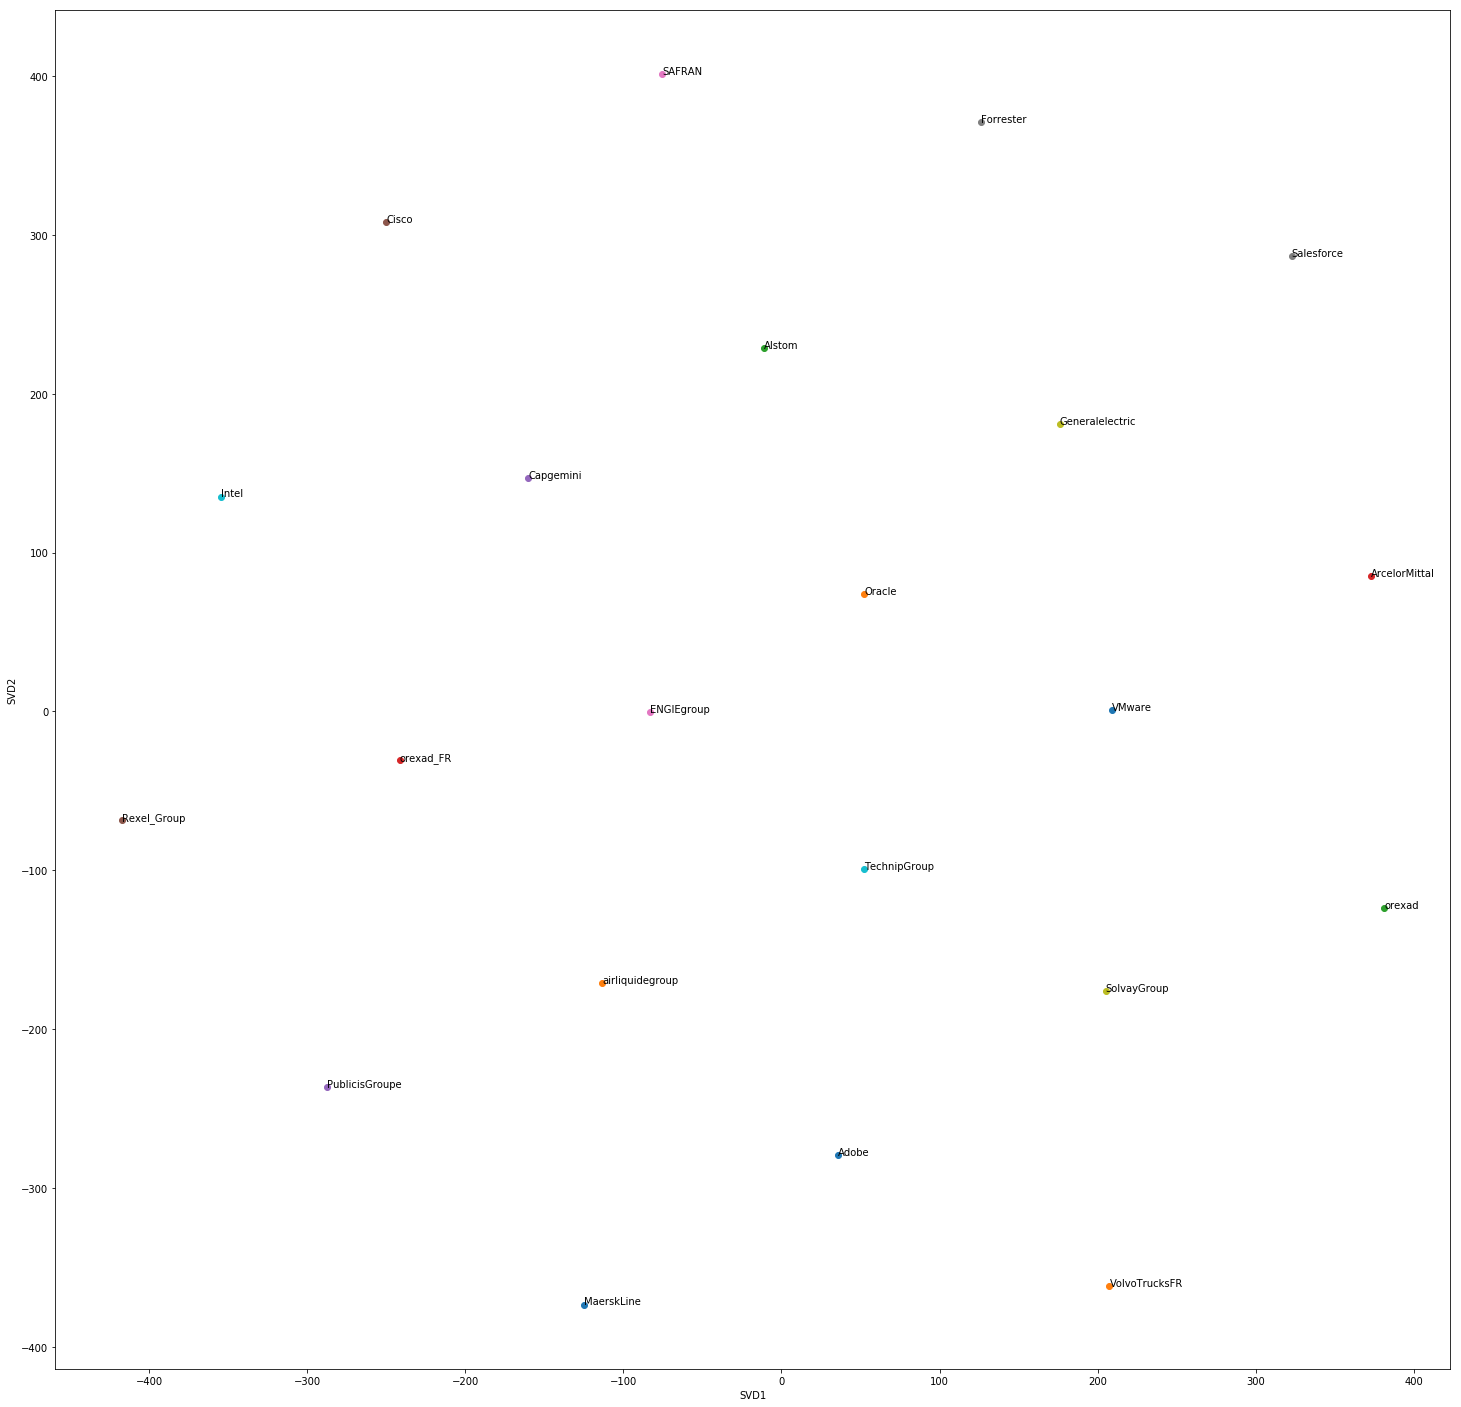

In [20]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=31, n_components=2, init='pca', n_iter=50000, method='exact')
two_d_embed = tsne.fit_transform(U)

fig = plt.figure(figsize=(25, 25))
ax = fig.add_subplot(1 ,1 ,1)
for i in range(len(l_e_vec))[:100]:
    ax.scatter(two_d_embed[i,0], two_d_embed[i,1])
    ax.annotate(companies[i][0], (two_d_embed[i,0], two_d_embed[i,1]))

plt.xlabel('SVD1')
plt.ylabel('SVD2')
plt.show()

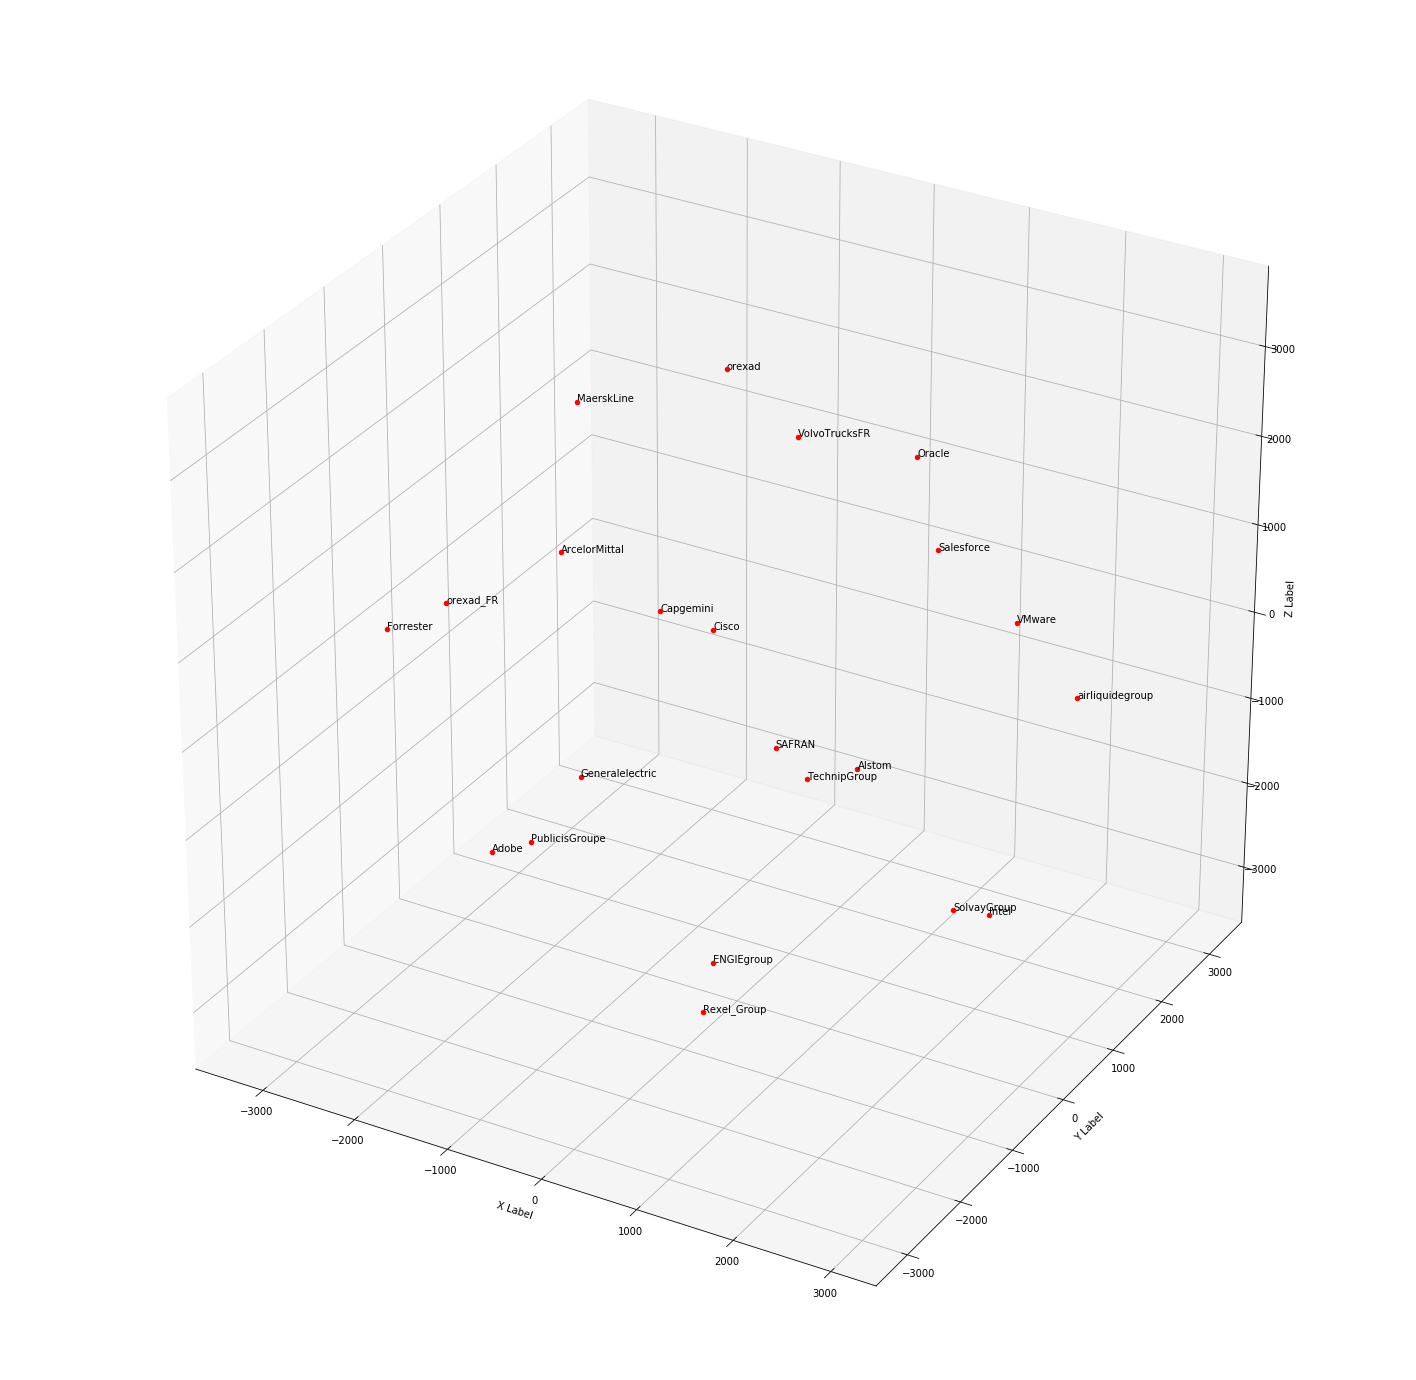

In [21]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

tsne = TSNE(perplexity=0, n_components=3, init='pca', n_iter=50000, method='exact')
three_d_embed = tsne.fit_transform(U)

fig = plt.figure(figsize=(25, 25))
ax = fig.add_subplot(111, projection='3d')

x = three_d_embed[:,0]
y = three_d_embed[:,1]
z = three_d_embed[:,2]


for index, (i, j, k) in enumerate(zip(x, y, z)):
    ax.scatter(i, j, k, c='r', marker='o')
#    ax.annotate(np.array(companies)[index, 0], x)
    ax.text(i, j, k,  np.array(companies)[index, 0], size=10, zorder=1, color='k') 

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

In [16]:
for i, word in enumerate(dictionary):
    print ("{:50}".format(word), r_e_vec[i][:2])

via                                                [ 0.32588126 -0.06505115]
cloud                                              [ 0.27467521 -0.05033203]
new                                                [ 0.23149983 -0.08173046]
see                                                [ 0.16295952  0.16946438]
will                                               [ 0.1455786  0.0272583]
now                                                [ 0.15225994  0.15663696]
top                                                [ 0.16906689  0.41121023]
ai                                                 [ 0.15148    -0.01959483]
great                                              [ 0.13271649 -0.08369946]
data                                               [ 0.12022388  0.01938615]
business                                           [ 0.11989193 -0.01495601]
thanks                                             [ 0.109016   -0.08798977]
report                                             [ 0.11860421  0.36643234]
l

core                                               [ 0.02465354 -0.02180362]
research                                           [ 0.0283901   0.04363081]
build                                              [ 0.02674858 -0.01536221]
real                                               [ 0.02612467  0.00808038]
got                                                [ 0.02524237 -0.02053601]
share                                              [ 0.02635551 -0.01081897]
change                                             [ 0.02435334 -0.00088414]
let                                                [ 0.02013833  0.0003736 ]
design                                             [ 0.02426182 -0.01619226]
learning                                           [ 0.0241286  -0.01417514]
many                                               [ 0.0264539  -0.01874365]
last                                               [ 0.02372628 -0.01362607]
ge                                                 [ 0.00595104 -0.00448863]

epmcloud                                           [ 0.00955408 -0.00330406]
goes                                               [ 0.00783475 -0.00516821]
vendor                                             [ 0.00831646  0.0124353 ]
night                                              [ 0.00779347 -0.00557104]
aws                                                [ 0.0080564   0.00970855]
investment                                         [ 0.00766557  0.00211094]
forum                                              [ 0.00674075 -0.00353014]
executive                                          [ 0.00862904 -0.00560719]
supporting                                         [ 0.00749202 -0.00255161]
senior                                             [ 0.00770867 -0.00648527]
client                                             [ 0.00714645 -0.00293659]
chip                                               [ 0.00733285 -0.00717341]
class                                              [ 0.00852507 -0.00508763]

ram                                                [ 0.00346601 -0.0020184 ]
brought                                            [ 0.00310443 -0.00241917]
capital                                            [ 0.00338682 -0.00362739]
rest                                               [ 0.00412925 -0.00239594]
feedback                                           [ 0.00387287 -0.00256572]
production                                         [ 0.00223865 -0.00108375]
engineers                                          [ 0.0029892  -0.00129351]
female                                             [ 0.00274112 -0.00262847]
ui                                                 [ 0.0041942  -0.00234657]
empower                                            [ 0.00355909 -0.00252354]
thursday                                           [ 0.00344707 -0.00264906]
augmented                                          [ 0.00398104  0.00230241]
embrace                                            [ 0.00439367 -0.00088022]

builds                                             [ 0.00262562 -0.00093724]
las                                                [ 0.00361861 -0.00236911]
quotes                                             [ 0.00190601 -0.00117899]
outcomes                                           [ 0.00256564  0.00053079]
views                                              [ 0.00269968 -0.00181023]
tuesday                                            [ 0.00293761  0.0017566 ]
west                                               [ 0.0031435  -0.00290304]
century                                            [ 0.0024115 -0.0026533]
chatbot                                            [ 0.00227679 -0.00154702]
helmet                                             [ 0.00256803 -0.00119419]
wednesday                                          [ 0.00225185 -0.00125578]
engaging                                           [ 0.00118588 -0.0003508 ]
busy                                               [ 0.00290954 -0.0015575 ]
p

forever                                            [ 0.00210726 -0.0007348 ]
dog                                                [ 0.00239362 -0.00163078]
max                                                [ 0.00145088 -0.00048165]
33                                                 [ 0.0013909  -0.00120762]
impossible                                         [ 0.00171749 -0.00157889]
arm                                                [  7.26787634e-05  -4.51821059e-05]
pbcs                                               [ 0.00154702 -0.00123269]
airwatch                                           [ 0.00135788 -0.00108871]
maurice                                            [ 0.00064011 -0.0003321 ]
boards                                             [ 0.00199002 -0.00112249]
edtech                                             [ 0.00207191 -0.00068596]
earlier                                            [ 0.00163896 -0.00053028]
required                                           [ 0.00167743 -0

fourth                                             [ 0.00124025 -0.00071998]
einsteinai                                         [ 0.00164643 -0.00029993]
russia                                             [ 0.00240742 -0.00287933]
elearning                                          [ 0.00178615 -0.00173376]
connector                                          [ 0.00076995  0.00067513]
effectiveness                                      [ 0.00147032 -0.00139976]
promo                                              [ 0.00124466 -0.00118202]
nope                                               [ 0.00149379  0.00062126]
principles                                         [ 0.00142855  0.00038181]
discovery                                          [ 0.00164419  0.00070679]
expo                                               [ 0.0014593  -0.00148333]
forrmktg                                           [ 0.0007515  -0.00027382]
speeds                                             [ 0.00157365  0.0065581 ]

historic                                           [ 0.00129673  0.00083271]
125                                                [ 0.00047611 -0.00037552]
michelle                                           [ 0.00086007 -0.00063042]
cap_elite                                          [ 0.00082177 -0.00065028]
forrdigital                                        [  3.54103231e-04   2.06605564e-05]
itfm                                               [ 0.00098626 -0.00085124]
realsense                                          [ 0.0012426   0.00522423]
icx                                                [ 0.00089317 -0.0003474 ]
dir                                                [ 0.00078883 -0.00064105]
bullshit                                           [ 0.00087678 -0.00022667]
crashing                                           [ 0.00132487 -0.00138205]
lmao                                               [ 0.00082143 -0.00070843]
projectmanagement                                  [ 0.0016029  -0

km                                                 [ 0.00097112 -0.00043904]
advocacy                                           [ 0.00087965 -0.00020612]
legit                                              [ 0.00094307 -0.00040765]
figured                                            [ 0.00048149 -0.00023878]
grads                                              [ 0.00079876  0.00065169]
translation                                        [ 0.00029276 -0.00018139]
controls                                           [ 0.00066762 -0.00060375]
obsolete                                           [ 0.00048918 -0.00031414]
outcome                                            [ 0.00075231 -0.00083   ]
crush                                              [ 0.00035787 -0.00016859]
dropping                                           [ 0.00099356 -0.00055314]
vast                                               [ 0.0007059  -0.00066542]
lisa                                               [ 0.00063876 -0.0005368 ]

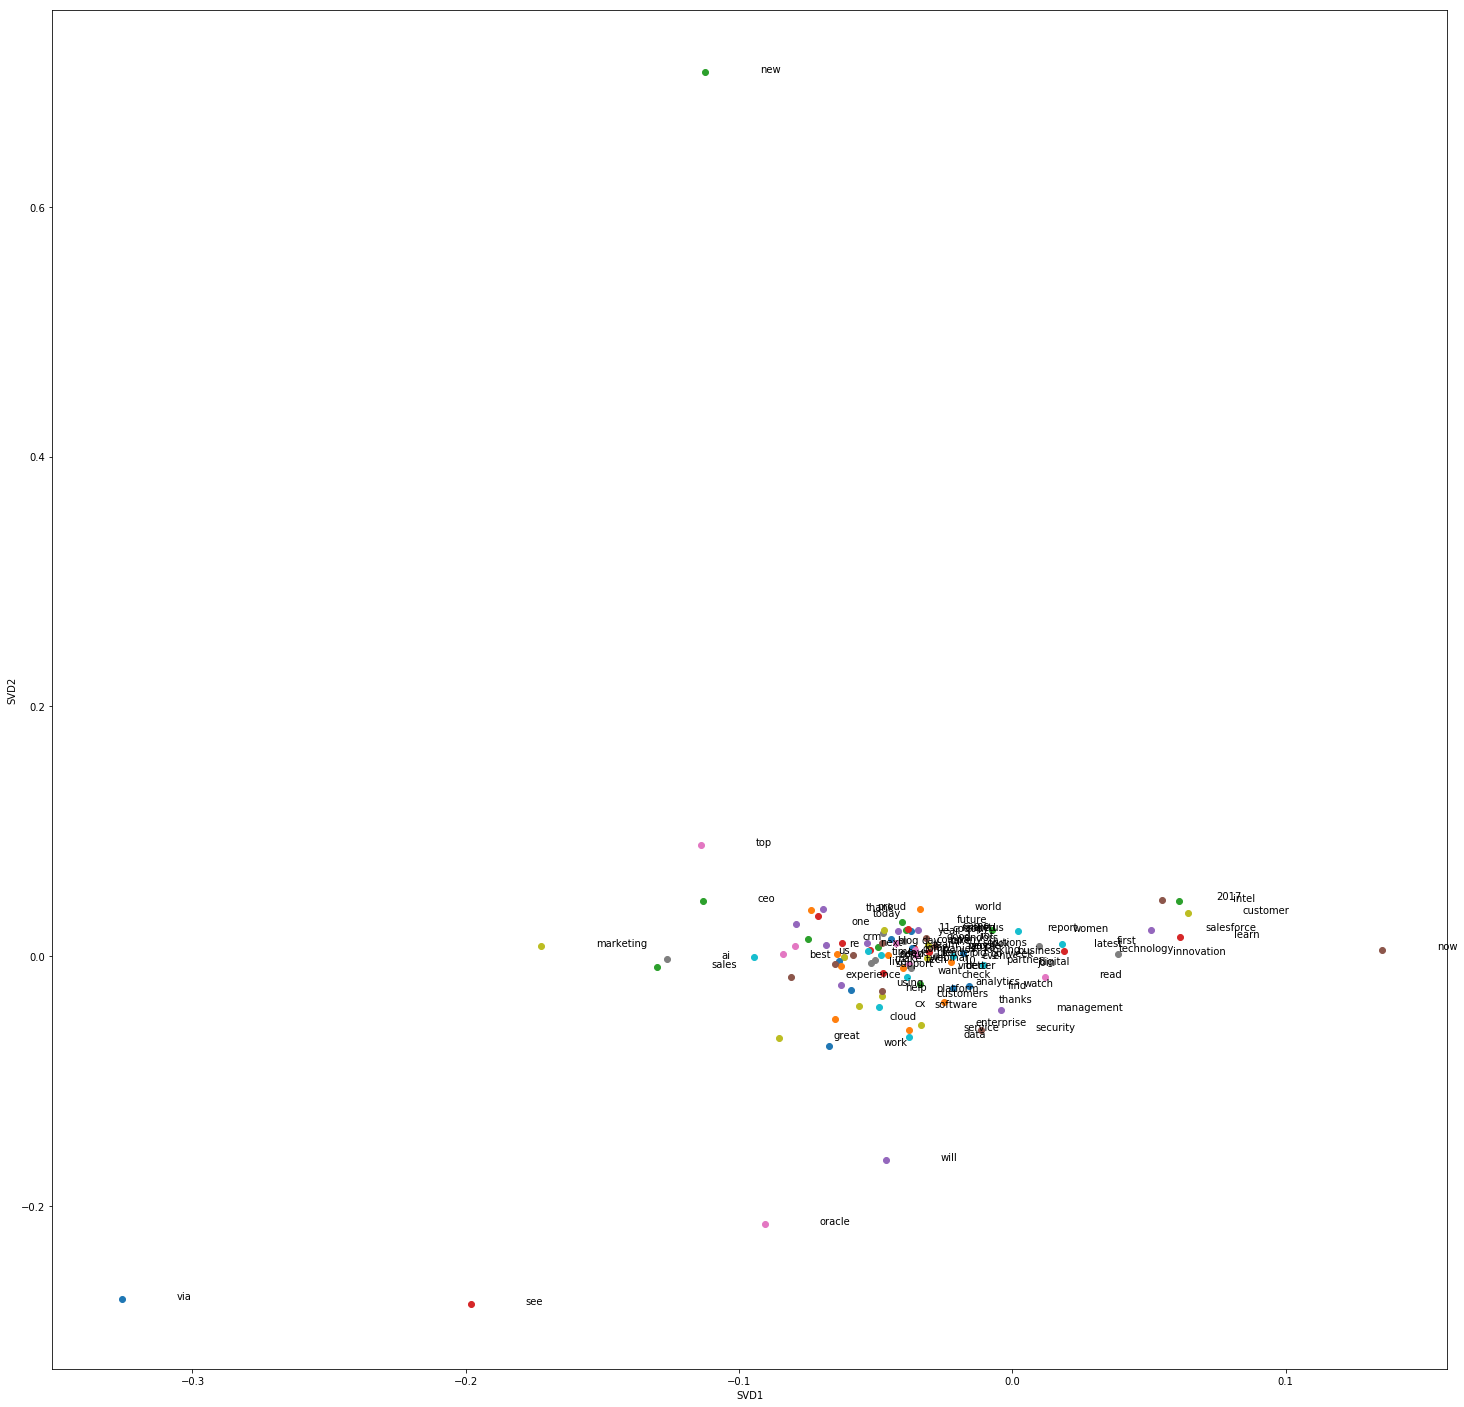

In [22]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(25, 25))
ax = fig.add_subplot(1,1,1)
for i in range(len(VT))[:100]:
    ax.scatter(VT[i,0], VT[i,1])
    ax.annotate(dictionary[i], (VT[i,0] + 0.02, VT[i,1]))

plt.xlabel('SVD1')
plt.ylabel('SVD2')
plt.show()

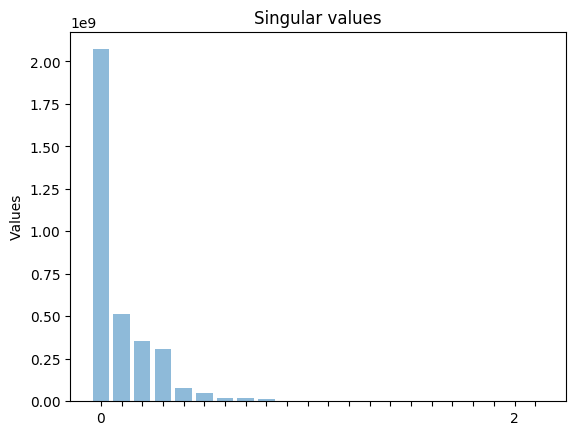

In [34]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

min = 0
max = 22
 
objects = list(map(lambda x: str(int(x/10)) if x % 20 == 0 else "", list(range(S[min:max].shape[0]))))
y_pos = np.arange(len(objects))
performance = np.power(S, 2)[min:max]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Values')
plt.title('Singular values')
 
plt.show()

In [36]:
dim = 5
saved_dim = -1
if os.path.exists(get_path('dim_svd.npy')):
    saved_dim = np.load(get_path('dim_svd.npy'))[0]
    
if not os.path.exists(get_path('svd_matrix.npy')) or dim != saved_dim:
    svd_matrix = np.dot(np.dot(U[:,:dim], SIGMA[:dim,:dim]), VT[:dim])
    np.save(get_path('svd_matrix.npy'), svd_matrix)
    np.save(get_path('dim_svd.npy'), [dim])
else:
    svd_matrix = np.load(get_path('svd_matrix.npy'))

svd_matrix.shape

(22, 5000)

In [23]:
e_val = np.sqrt(e_val[np.argsort(-e_val)])
r_e_vec_t = r_e_vec.T
Sig = diag(e_val, (l_e_vec.shape[0], r_e_vec_t.shape[1]))

In [24]:
dim = 10

In [25]:
print (l_e_vec.shape, " ", Sig.shape, " ", r_e_vec_t.shape)
print (l_e_vec[:,:dim].shape, " ", Sig[:dim,:dim].shape, " ", r_e_vec_t[:dim].shape)

(22, 22)   (22, 5000)   (5000, 5000)
(22, 10)   (10, 10)   (10, 5000)


In [28]:
if not os.path.exists(get_path('eigen_matrix.npy')):
    eigen_matrix = np.dot(np.dot(l_e_vec[:,:dim], Sig[:dim,:dim]), r_e_vec_t[:dim])
    np.save(get_path('eigen_matrix.npy'), eigen_matrix)
else:
    eigen_matrix = np.load(get_path('eigen_matrix.npy'))

eigen_matrix.shape

(22, 5000)

In [29]:
def cosine(a, b):
    return 0.0 if np.linalg.norm(a) * np.linalg.norm(b) == 0.0 else np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [30]:
def get_matching_words(company_vector, unique_tweets_matrix):
    maching_rates = []
    for i, pv in enumerate(unique_tweets_matrix):
        maching_rates.append([i, cosine(company_vector, pv)])
    maching_rates = np.array(maching_rates)
    maching_rates = maching_rates[np.flip(maching_rates[:, 1].argsort(), 0)]
    return maching_rates

def get_matching_words_matrix(matrix, unique_tweets_matrix):
    uxp = []
    for company_vector in matrix[:3]:
        uxp.append(get_matching_words(company_vector, unique_tweets_matrix))
    return uxp

def print_matching_words(maching_rates, company, unique_corpus, n=10, print_last=False):
    print("First {}".format(n))
    for maching_rate in maching_rates[:n]:
        print(u'{} {:20} n° {} => {}'.format(company[0], maching_rate[1], int(maching_rate[0]), unique_corpus[int(maching_rate[0])]))
    if print_last:
        print("Last {}".format(n))
        for maching_rate in maching_rates[-n:]:
            print(u'{} {:20} n° {} => {}'.format(company[0], maching_rate[1], int(maching_rate[0]), unique_corpus[int(maching_rate[0])]))

def print_matching_words_matrix(uxp, companies, unique_corpus):
    for i, maching_rates in enumerate(uxp):
        print_matching_words(maching_rates, companies[i], unique_corpus, 5)


In [37]:
company_id = company_id_from_name("Intel", companies)
mp = get_matching_words(matrix[company_id], unique_tweets_matrix)
print_matching_words(mp, companies[company_id], unique_corpus, 10, True)

First 10
Intel   0.4180351063323439 n° 219812 => ['new', 'intel', 'perineum']
Intel   0.4039161589021318 n° 99054 => ['enter', 'win', 'new', 'gaming', 'pc', 'time', 'fight', 'banished', 'halowars2']
Intel   0.4039161589021318 n° 99057 => ['enter', 'win', 'new', 'gaming', 'pc', 'time', 'fight', 'banished', 'halowars2', 'freepc']
Intel   0.3999068027157039 n° 223533 => ['next', 'years', 'ai', 'will', 'frenetic', 'says', 'intel', 'new', 'ai', 'chief', 'via']
Intel   0.3914846879009048 n° 146120 => ['hey', 'enter', 'win', 'new', 'gaming', 'pc', 'time', 'fight', 'banished', 'halowars2']
Intel   0.3910253841424142 n° 231437 => ['one', 'big', 'step', 'ai', 'intel', 'new', 'self', 'learning', 'chip', 'loihi', 'via']
Intel   0.3906952595659992 n° 298496 => ['stop', 'enter', 'win', 'new', 'gaming', 'pc', 'time', 'fight', 'banished', 'halowars2']
Intel   0.3899894159854611 n° 99056 => ['enter', 'win', 'new', 'gaming', 'pc', 'time', 'fight', 'banished', 'halowars2', 'don', 'mind']
Intel  0.3887288

In [38]:
company_tweets = indexed_tweets_from_company("Intel", companies, 100)
for i, tweet in company_tweets[:100]:
    print('n° {}: {}'.format(i, tweet))

n° 123095: ['getting', 'started', 'gracious', 'employee', 'set', 'account', 'tiny', 'atom', 'chip', 'big', 'news', 'today']
n° 318170: ['thanks', 'stopping', 'today', 'mr', 'president', 'speaking', 'intel', 'fab', '42', 'chandler', 'az', 'today']
n° 357671: ['will', 'support', 'productions', 'black', 'proud', 'esports', 'racists', 'eg', 'biggots']
n° 300597: ['success', 'breeds', 'complacency', 'complacency', 'breeds', 'failure', 'paranoid', 'survive', 'andy', 'grove', 'co', 'founder', 'intel', 'quote']
n° 300575: ['succeed', 'try', 'decode', 'quote']
n° 358274: ['windows8', 'arrives', 'today', 'along', 'brand', 'new', 'intel', 'powered', 'devices', 'great', 'minds', 'ultrabook', 'inteltablets']
n° 225153: ['noblest', 'pleasure', 'joy', 'understanding', 'leonardo', 'da', 'vinci', 'quote']
n° 113834: ['fit', '200', '22nm', 'transistors', 'across', 'diameter', 'average', 'human', 'hair', 'dothemath']
n° 95186: ['educate', 'girl', 'will', 'change', 'world', 'girlrising']
n° 31312: ['back'

In [40]:
r_e_vec.shape, l_e_vec.shape

((5000, 5000), (22, 22))

In [41]:
word_vector = r_e_vec[dictionary.tolist().index('man')]
word_vector2 = r_e_vec[dictionary.tolist().index('women')]
cosine(word_vector, word_vector2)

3.989863994746657e-17

In [42]:
def print_compos(compos):
    for index, compo_id in enumerate(compos):
        compo = unique_corpus[int(compo_id[0])]
        print(index + 1, end=') ')
        for i, word in enumerate(compo):
            end = ", " if i < len(compo) - 1 else ".\n\n"
            print("{}".format(word.replace("_", " ")), end=end)
        

In [43]:
import random

maching_rates = np.concatenate([mp[:10], mp[-10:]], 0)
print_compos(maching_rates)
np.random.shuffle(maching_rates)
print_compos(maching_rates)

1) new, intel, perineum.

2) enter, win, new, gaming, pc, time, fight, banished, halowars2.

3) enter, win, new, gaming, pc, time, fight, banished, halowars2, freepc.

4) next, years, ai, will, frenetic, says, intel, new, ai, chief, via.

5) hey, enter, win, new, gaming, pc, time, fight, banished, halowars2.

6) one, big, step, ai, intel, new, self, learning, chip, loihi, via.

7) stop, enter, win, new, gaming, pc, time, fight, banished, halowars2.

8) enter, win, new, gaming, pc, time, fight, banished, halowars2, don, mind.

9) win, something, hahahahahaha, enter, win, new, gaming, pc, time, fight, banished, halowars2.

10) next, years, ai, will, frenetic, says, naveen, rao, intel, new, ai, chief.

11) givingback.

12) giscampsiliconvalley, 25august.

13) girlpower.

14) girlspowertech, girlswhocode.

15) girlspowertech, girlsrock.

16) girlspowertech, ciscostem.

17) girlsinit, girlspowertech, ciscostem.

18) girlsinict, girlsinstem, girlsintech.

19) girlpower, oracledigital.

20) 1

In [44]:
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=50, n_components=2, init='pca', n_iter=50000, method='exact')
two_d_embed = tsne.fit_transform(matrix)

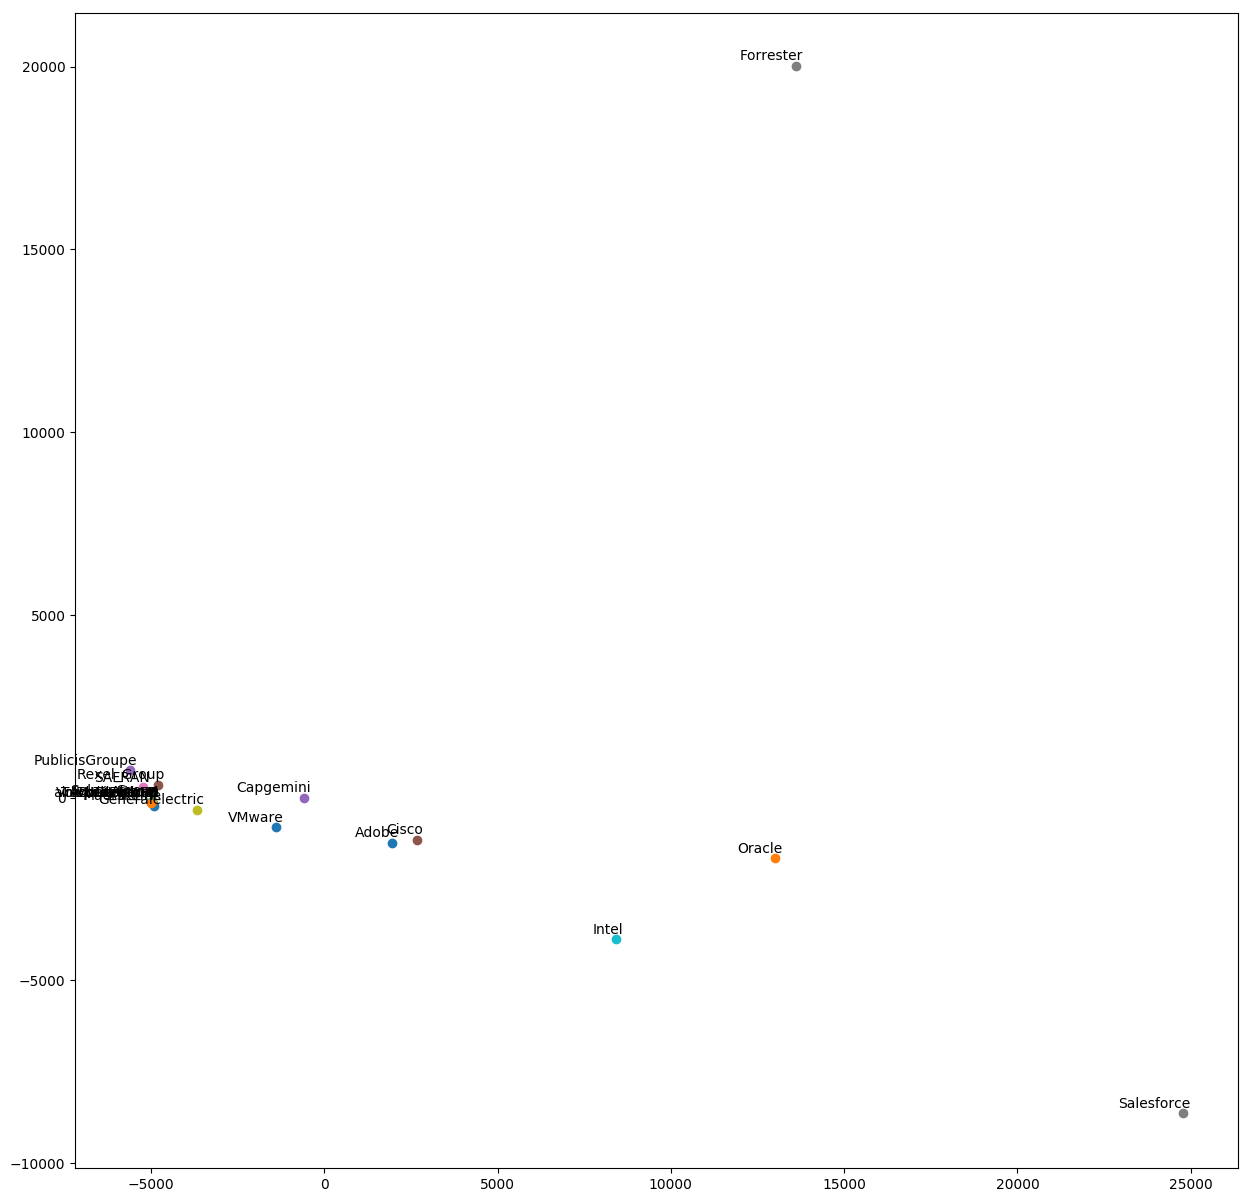

In [45]:
from matplotlib import pylab

def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15,15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                       ha='right', va='bottom')
    pylab.show()

plot(two_d_embed, np.array(companies)[:, 0])

In [39]:
company_from_name('Alstom', companies)[3]

1838